<a href="https://colab.research.google.com/github/Bohdan-at-Kulinich/Machine-Learning/blob/main/Regression_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Regression: prediction of a continous value instead of a discrete label. 
# Example: Boston housing price dataset. 
# It has relatively few data points: 506 split as 404 training samples and 102 test samples.
# Each feature has a different scale. 

In [2]:
# Loadin the Boston housing dataset:

from tensorflow.keras.datasets import boston_housing 

(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

65536/57026 [==================================] - 0s 0us/step


In [ ]:
# the shape of the data:

train_data.shape

(404, 13)

In [ ]:
test_data.shape

# 404 training samples and 102 test samples each with 13 numerical features 

(102, 13)

In [ ]:
# the targest are the median values of owner-occupied homes (in thousands of $) 

train_targets [:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [3]:
# Preparing the data: 

# to deal with the different range of the feature scales the best practices is 
# feature normalization: for each feature in the input data (column),
# we subtract the mean of the feature and divide by the standard deviation;
# the feature becomes centered around 0 and has a unit standard deviation:

mean = train_data.mean(axis=0)
train_data -= mean 

std = train_data.std(axis=0)
train_data /= std 

test_data -= mean 
test_data /= std 

# the quantities used for normalizing the test data are computed using only the training data 
# ! never use any quantity computed on the test data in the workflow 

In [4]:
# Building the model: 
# since only few samples are available, we use a very small model with two intermediate layers, each with 64 units. 

from tensorflow import keras 
from tensorflow.keras import layers 

def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model 

# In  general, for scalar regression (predicting a single continous value),
# the model ends with a single unit and no activation: a linear layer. 
# Thus, the model is free to learn to predict values in any range. 

# Loss function: mse = mean squared error: the square of the difference between the predictions and the targets.
# usually used for regression problems 

# Metric: mae = mean absolute error: absolute value of the difference between the predictions and the targets.

In [ ]:
# Validation using K-fold cross-validation:
# split the available data into K partitions (4 or 5),
# instantiate K identical model,
# train each model on K-1 partitions and evaluate on the ramaining partition.
# The validation score is the average of the K validation scores obtained. 

import numpy as np 

k = 4 
num_val_samples = len(train_data) // k 
num_epochs = 100 
all_scores = [] 

for i in range(k):
  print(f"Processing fold # {i}")
  
  # data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] 

  # data from all other partitions
  partial_train_data = np.concatenate( 
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0
  )
  partial_train_targets = np.concatenate( 
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0
  )

  # build and train the model in silent mode: verbose=0
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=16, verbose=0) 
  
  # evaluate the model on the validation data
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)


Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [ ]:
all_scores
np.mean(all_scores)

2.3315610885620117

In [5]:
# Saving the validation logs at each fold: 
import numpy as np 

k = 4
num_val_samples = len(train_data) // k 
num_epochs = 500 
all_scores = []
all_mae_histories = [] 

for i in range(k):
  print(f"Processing fold #{i}")

  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate( 
      [train_data[: i * num_val_samples], 
       train_data[(i + 1) * num_val_samples:]],
       axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0
  )

  model = build_model()
  history = model.fit (partial_train_data, partial_train_targets, 
                       validation_data=(val_data, val_targets),
                       epochs=num_epochs, batch_size=16, verbose=0)
  
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history) 


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [6]:
# building the history of successive mean K-fold validation scores:

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs) 
]

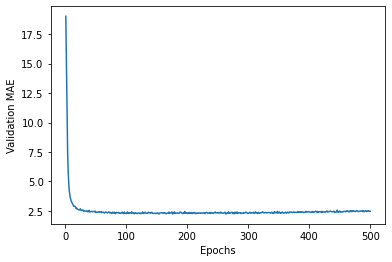

In [11]:
# Plot validation scores:

import matplotlib.pyplot as plt 

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# Since the validation value for the first few epochs is much higher, the plot is difficult to read

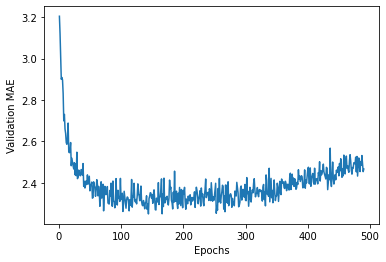

In [12]:
# Ploting validation scores, excluding the first 10 data points:

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# The validations stops improving significantly after 120-140 epochs, after which begins overfitting 

In [13]:
# Training the final model: 

#  get a fresh, compiled model:
model = build_model() 

# train the model on all of the training data:
model.fit(train_data, train_targets, 
          epochs=130, batch_size=16, verbose=0)

# evaluate the model on the test data: 
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 17.0164 - mae: 2.5950


In [14]:
test_mae_score

2.5949504375457764

In [17]:
# Generating predictions on new data: 
# predict() returns the model's guess for the sample's price in thousands $

predictions = model.predict(test_data)
predictions[2]

array([21.442638], dtype=float32)